wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/valeriya/.netrc.
wandb: Currently logged in as: vslovik (homeserve) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



🔗 Initializing Weights & Biases...


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


✓ Wandb initialized. View at: https://wandb.ai/homeserve/france-hvac/runs/34q26xce

📊 Original quote data: 38,333 quotes from 25,930 customers

STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES
Creating enhanced customer features...
  Total customers: 25,930
✓ Created features for 25,930 customers
✓ New features: ['numero_compte', 'total_quotes', 'converted', 'avg_days_between_quotes', 'std_days_between_quotes', 'max_days_between_quotes', 'engagement_density', 'price_trajectory', 'unique_product_families', 'product_consistency']...
Creating sequence features (this may take a moment)...
  Total customers: 25,930
✓ Created 10,723 sequence observations
✓ Features include: recent patterns leading up to each quote

🔧 ENCODING & PREPARING FOR MODELING...
  Preparing Customer Features...
  Features: 14, Samples: 25930

🔧 ENCODING & PREPARING FOR MODELING...
  Preparing Sequence Features...
  Features: 22, Samples: 10723
Multi-quote sequences: 10,723 observations
Sequence conversion rate: 24.8%

T

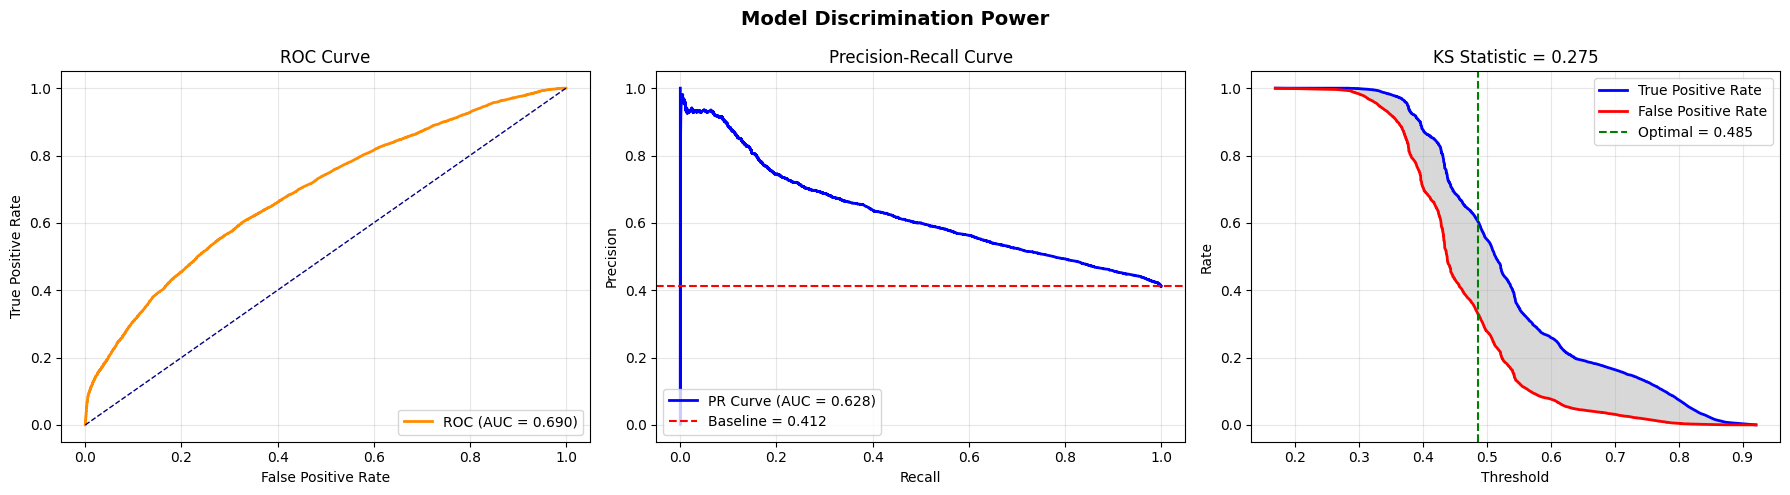

• ROC-AUC: 0.6896
• PR-AUC: 0.6276
• KS Statistic: 0.275 (WEAK discrimination)
• Optimal Threshold: 0.485

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.771
Decile 10 mean prob: 0.339


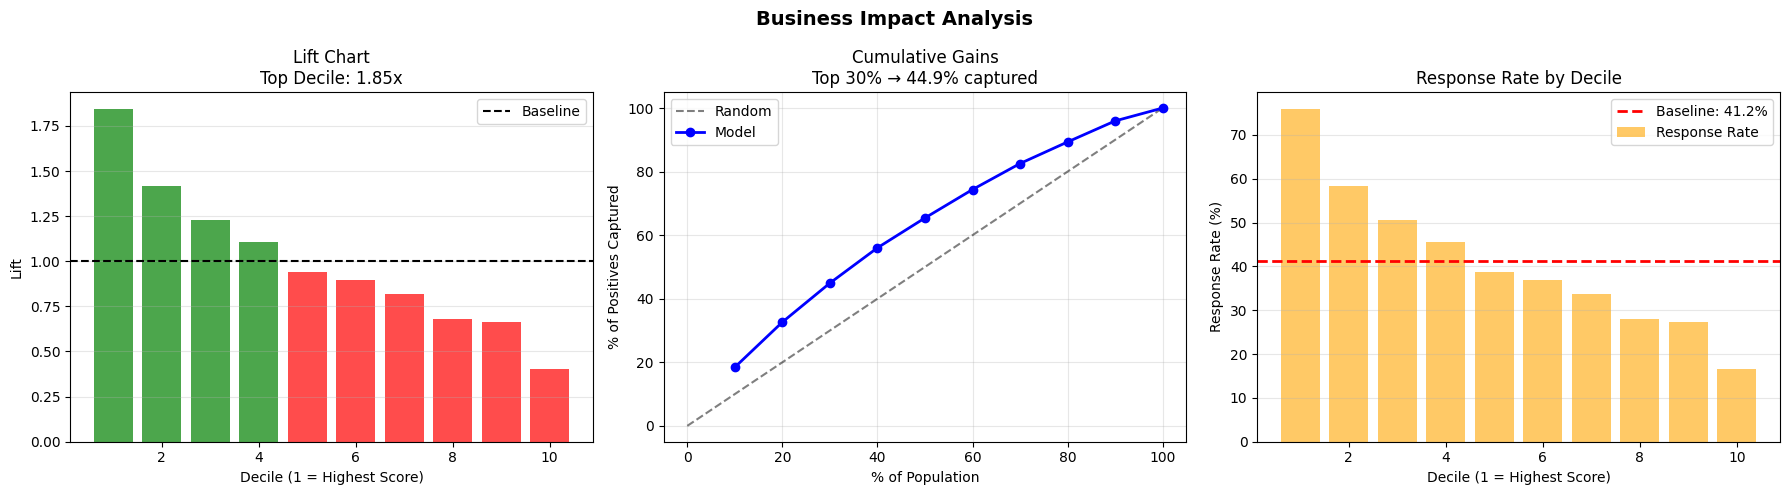

• Top Decile Lift: 0.41x
• Top 30% captures: 44.9% of positives
• Baseline response rate: 41.2%
• Top decile response: 76.0%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


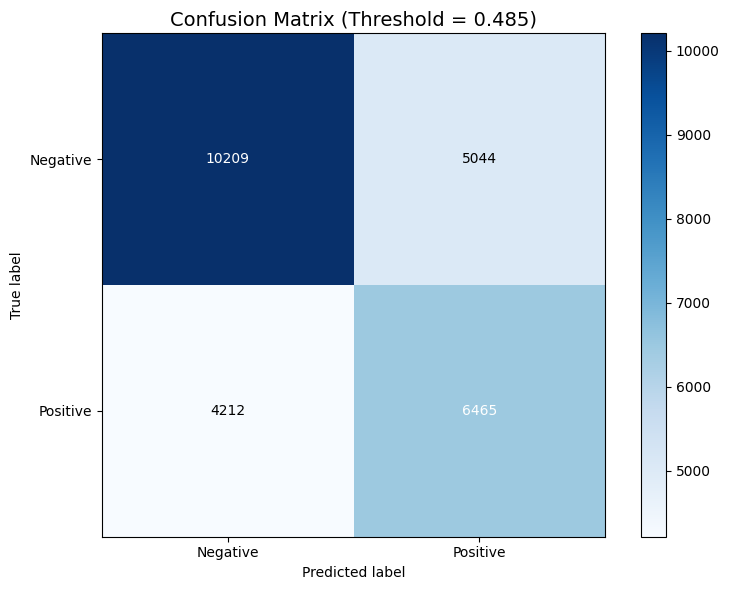

At threshold 0.485:
• Accuracy: 0.643
• Precision: 0.562
• Recall: 0.606
• F1-Score: 0.583
• True Positives: 6465
• False Positives: 5044
• True Negatives: 10209
• False Negatives: 4212

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.275 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.41x better than random
   Coverage: Top 30% → 44.9% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6896 (Excellent if >0.8)
   PR-AUC: 0.6276 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.485
   Precision at threshold: 0.562
   Recall at threshold: 0.606

🧪 TEST 2: SEQUENCE FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.738
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


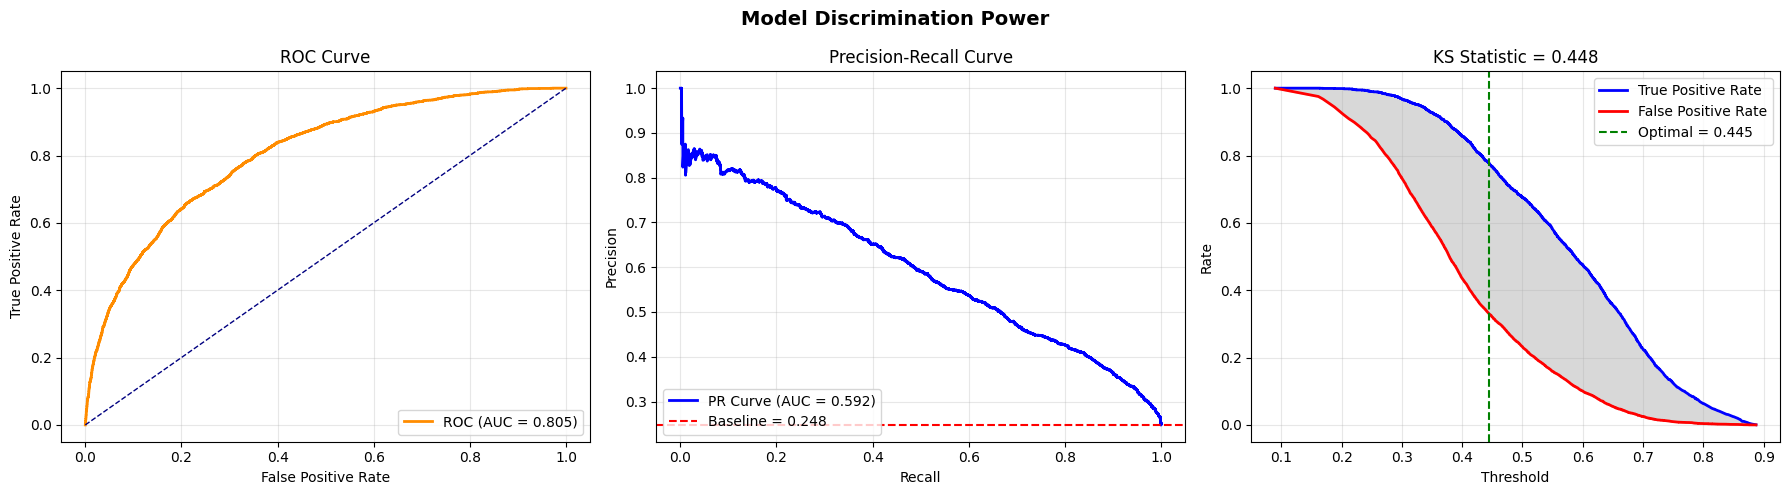

• ROC-AUC: 0.8046
• PR-AUC: 0.5919
• KS Statistic: 0.448 (GOOD discrimination)
• Optimal Threshold: 0.445

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.745
Decile 10 mean prob: 0.191


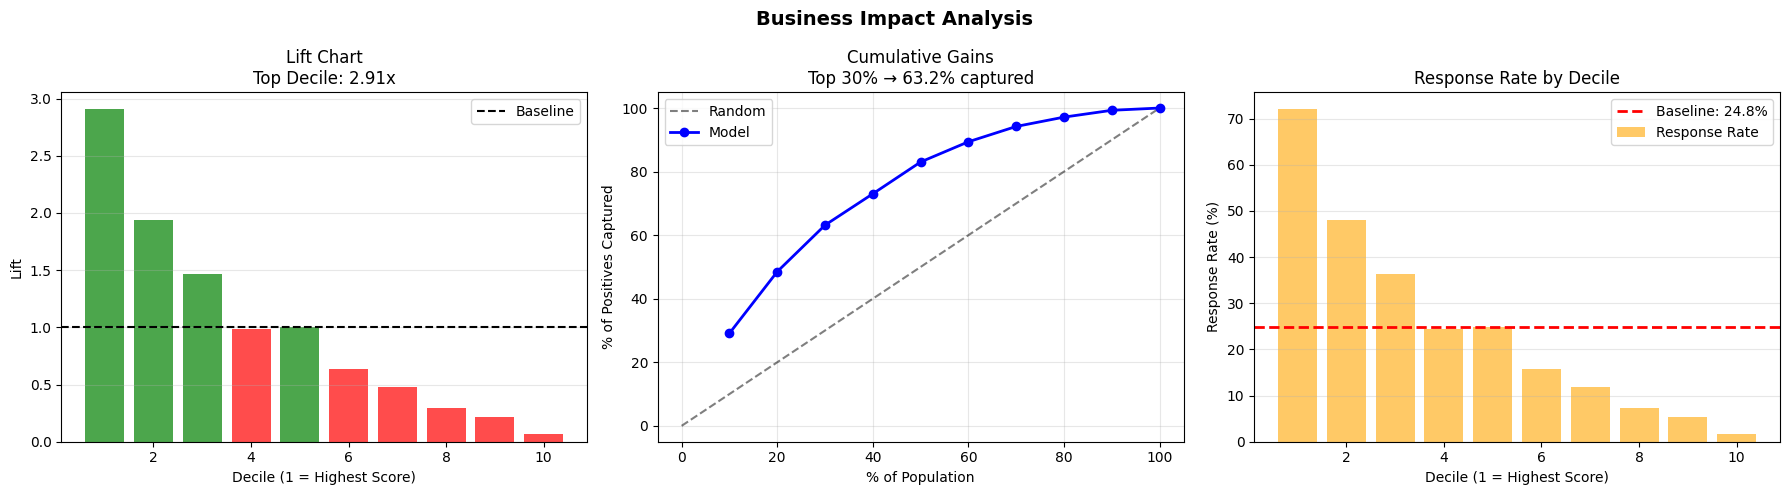

• Top Decile Lift: 0.07x
• Top 30% captures: 63.2% of positives
• Baseline response rate: 24.8%
• Top decile response: 72.1%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


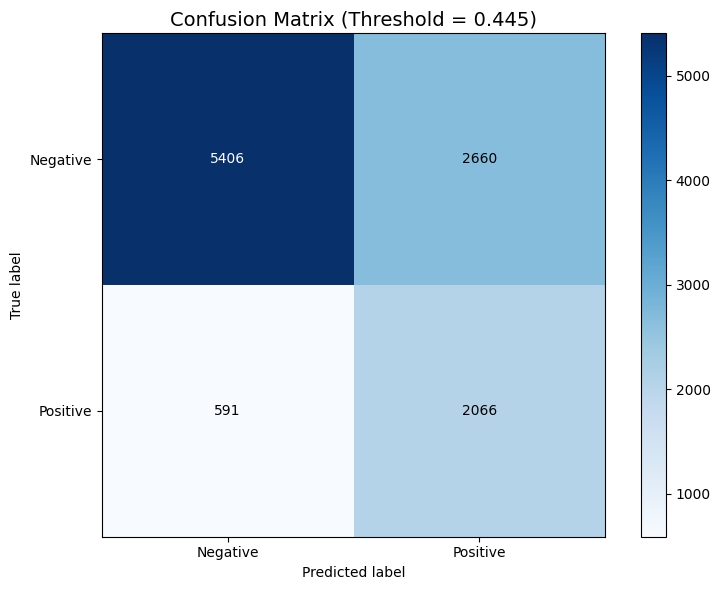

At threshold 0.445:
• Accuracy: 0.697
• Precision: 0.437
• Recall: 0.778
• F1-Score: 0.560
• True Positives: 2066
• False Positives: 2660
• True Negatives: 5406
• False Negatives: 591

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.448 (GOOD discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.07x better than random
   Coverage: Top 30% → 63.2% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.8046 (Excellent if >0.8)
   PR-AUC: 0.5919 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.445
   Precision at threshold: 0.437
   Recall at threshold: 0.778

📊 Creating model comparison...

💾 Saving best model to wandb...


ValueError: Path is not a file: 'sequence_features_model.pkl'

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from etl.util import prepare_dataset_without_leakage
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features import create_sequence_features
from ml_training.train_rf import train_rf
from ml_evaluation.dashboard import model_evaluation_report

import wandb  # Add wandb import
from wandb.sklearn import plot_roc, plot_confusion_matrix

import wandb
wandb.init(project="france-hvac", name="sequence-feature-test")

import warnings
warnings.filterwarnings('ignore')

# ============ INITIALIZE WANDB ============
print("\n🔗 Initializing Weights & Biases...")
run = wandb.init(
    project="france-hvac",
    name="sequence-feature-experiment",
    config={
        "test_size": 0.2,
        "random_state": 42,
        "rf_n_estimators": 100,
        "rf_max_depth": 8,
        "rf_min_samples_split": 50,
        "window_days": 90
    }
)

print(f"✓ Wandb initialized. View at: {run.get_url()}")

# Load original clean quote data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

print(f"\n📊 Original quote data: {len(df_quotes):,} quotes from {df_quotes['numero_compte'].nunique():,} customers")

# ============ LOG DATASET INFO ============
wandb.log({
    "dataset/n_quotes": len(df_quotes),
    "dataset/n_customers": df_quotes['numero_compte'].nunique()
})

print("\n" + "="*80)
print("STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES")
print("="*80)

# 1. Enhanced customer features
enhanced_customers = create_customer_features(df_quotes)

# ============ LOG CUSTOMER FEATURE STATS ============
wandb.log({
    "features/customer/n_features": len(enhanced_customers.columns),
    "features/customer/conversion_rate": enhanced_customers['converted'].mean()
})

# 2. Sequence features (for multi-quote customers)
sequence_df = create_sequence_features(df_quotes, window_days=wandb.config.window_days)
sequence_df = pd.merge(sequence_df, enhanced_customers, on='numero_compte', how='left')

X_customer = enhanced_customers.drop(columns=['numero_compte', 'converted'], errors='ignore')
y_customer = enhanced_customers['converted']
X_customer_clean, y_customer_clean = prepare_features(X_customer, y_customer, "Customer Features")

X_sequence = sequence_df.drop(columns=['numero_compte', 'current_converted', 'current_product_family', 'converted'], errors='ignore')
y_sequence = sequence_df['current_converted']
X_sequence_clean, y_sequence_clean = prepare_features(X_sequence, y_sequence, "Sequence Features")

print(f"Multi-quote sequences: {len(X_sequence):,} observations")
print(f"Sequence conversion rate: {y_sequence.mean():.1%}")

# ============ LOG SEQUENCE FEATURE STATS ============
wandb.log({
    "features/sequence/n_sequences": len(X_sequence),
    "features/sequence/conversion_rate": y_sequence.mean(),
    "features/sequence/n_features": len(X_sequence.columns)
})

print("\n" + "="*80)
print("TESTING FEATURE IMPROVEMENT")
print("="*80)

# Test 1: Customer features only (baseline)
print("\n🧪 TEST 1: ENHANCED CUSTOMER FEATURES (Baseline)")
result_customer = train_rf(
    X_customer_clean, 
    y_customer_clean, 
    'improved_customer_model',
    wandb_run=run  # Pass wandb run to training function
)

# ============ ADD THIS LINE ============
wandb.log({"customer_model_auc": result_customer['metrics']['auc']})
# ============ END ADDITION ============

df = X_customer_clean.copy()
df['converted'] = y_customer_clean
model_evaluation_report(df, result_customer['model'], result_customer['features'], 'converted')

# ============ ADD VISUALIZATIONS FOR CUSTOMER MODEL ============
# Create ROC curve visualization
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predictions for visualization
X_train, X_test, y_train, y_test = train_test_split(
    X_customer_clean, y_customer_clean, test_size=0.2, random_state=42
)
y_pred_proba = result_customer['model'].predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Customer Features Model')
ax.legend(loc="lower right")

wandb.log({"customer_model/roc_curve": wandb.Image(fig)})
plt.close()

# Test 2: Sequence features (if available)
print("\n🧪 TEST 2: SEQUENCE FEATURES (Advanced)")
result_sequence = train_rf(
    X_sequence_clean, 
    y_sequence_clean, 
    'sequence_prediction_model',
    wandb_run=run  # Pass wandb run to training function
)

# ============ ADD THIS LINE ============
wandb.log({"sequence_model_auc": result_sequence['metrics']['auc']})
# ============ END ADDITION ============

df = X_sequence_clean.copy()
df['converted'] = y_sequence_clean
model_evaluation_report(df, result_sequence['model'], result_sequence['features'], 'converted')

# ============ CREATE COMPARISON VISUALIZATION ============
print("\n📊 Creating model comparison...")

comparison_data = []
for model_name, result in [("Customer", result_customer), ("Sequence", result_sequence)]:
    comparison_data.append([
        model_name,
        result['metrics']['train_size'] + result['metrics']['test_size'],
        result['metrics']['conversion_rate'],
        result['metrics']['auc'],
        result['metrics']['accuracy'],
        result['metrics']['f1'],
        len(result['features'])
    ])

comparison_df = pd.DataFrame(
    comparison_data,
    columns=['Model', 'Samples', 'Conv_Rate', 'AUC', 'Accuracy', 'F1', 'N_Features']
)

# Log comparison table
comparison_table = wandb.Table(dataframe=comparison_df)
wandb.log({
    "model_comparison/table": comparison_table,
    "model_comparison/auc_chart": wandb.plot.bar(
        comparison_table, "Model", "AUC", title="AUC Comparison"
    ),
    "model_comparison/f1_chart": wandb.plot.bar(
        comparison_table, "Model", "F1", title="F1 Score Comparison"
    )
})

# ============ LOG BEST MODEL AS ARTIFACT ============
print("\n💾 Saving best model to wandb...")

# Determine best model
if result_customer['metrics']['auc'] > result_sequence['metrics']['auc']:
    best_result = result_customer
    best_name = "customer_features_model"
else:
    best_result = result_sequence
    best_name = "sequence_features_model"

# Create artifact
artifact = wandb.Artifact(
    name=best_name,
    type="model",
    description=f"Best performing model with AUC {best_result['metrics']['auc']:.3f}",
    metadata={
        "auc": best_result['metrics']['auc'],
        "accuracy": best_result['metrics']['accuracy'],
        "f1": best_result['metrics']['f1'],
        "n_features": len(best_result['features']),
        "n_samples": best_result['metrics']['train_size'] + best_result['metrics']['test_size'],
        "conversion_rate": best_result['metrics']['conversion_rate']
    }
)

# Add model file
artifact.add_file(f"{best_name}.pkl")

# Add feature importance
feature_importance = pd.DataFrame({
    'feature': best_result['features'],
    'importance': best_result['model'].feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.to_csv(f"{best_name}_importance.csv", index=False)
artifact.add_file(f"{best_name}_importance.csv")

wandb.log_artifact(artifact)

# ============ LOG SUMMARY METRICS ============
wandb.run.summary["best_model"] = best_name
wandb.run.summary["best_auc"] = best_result['metrics']['auc']
wandb.run.summary["customer_auc"] = result_customer['metrics']['auc']
wandb.run.summary["sequence_auc"] = result_sequence['metrics']['auc']
wandb.run.summary["improvement"] = result_sequence['metrics']['auc'] - result_customer['metrics']['auc']

# ============ FINISH ============
print("\n" + "="*80)
print("EXPERIMENT COMPLETE")
print("="*80)
print(f"✅ View results at: {wandb.run.get_url()}")
print(f"🏆 Best model: {best_name} (AUC: {best_result['metrics']['auc']:.3f})")
print(f"📈 Customer AUC: {result_customer['metrics']['auc']:.3f}")
print(f"📈 Sequence AUC: {result_sequence['metrics']['auc']:.3f}")


wandb.finish()
print(f"\n✅ Tracked on wandb.ai/france-hvac")